# Elastic horizontal free-surface

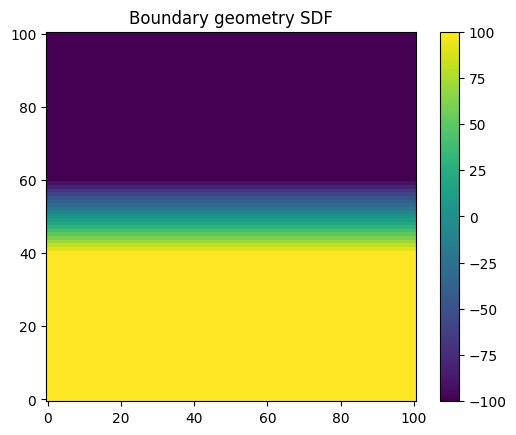

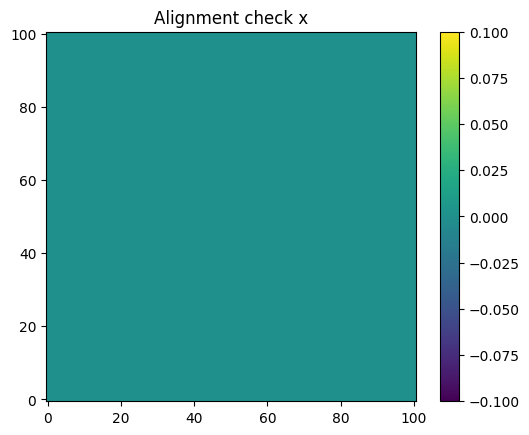

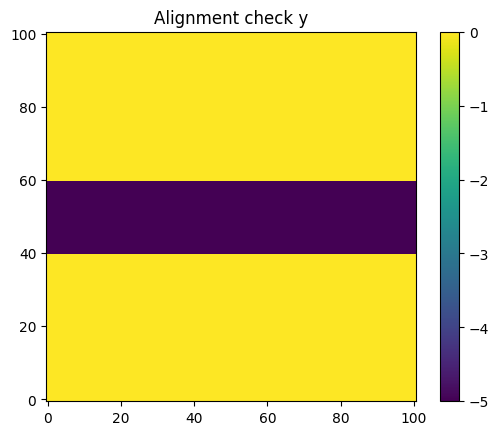

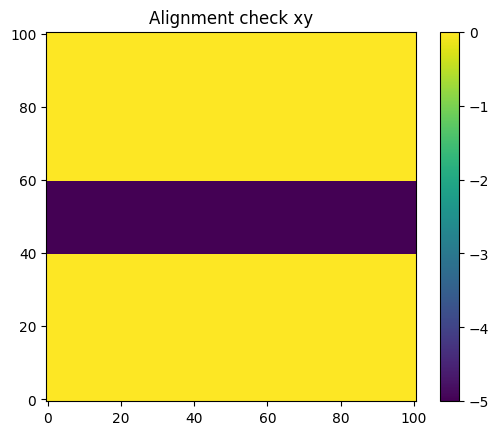

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import matplotlib.pyplot as plt
import numpy as np

def read_sdf(surface):
    """Unpickle an sdf"""
    fname = 'sdfs/' + surface + '.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the horizontal 2D sdf
sdf = read_sdf('flat_surface_2d')

# Load the staggered sdfs
sdf_x = read_sdf('flat_surface_2d_x')
sdf_y = read_sdf('flat_surface_2d_y')
sdf_xy = read_sdf('flat_surface_2d_xy')

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

# It is a good idea to make sure your signed distance functions are aligned
# Misaligned SDFs can result in considerable weirdness
plt.imshow(sdf_x.data.T-sdf.data.T, origin='lower')
plt.title("Alignment check x")
plt.colorbar()
plt.show()

plt.imshow(sdf_y.data.T-sdf.data.T, origin='lower')
plt.title("Alignment check y")
plt.colorbar()
plt.show()

plt.imshow(sdf_xy.data.T-sdf.data.T, origin='lower')
plt.title("Alignment check xy")
plt.colorbar()
plt.show()

In [2]:
from schism import BoundaryGeometry
import sympy as sp

x, y = sdf.grid.dimensions
h_x = x.spacing
h_y = y.spacing
zero = sp.core.numbers.Zero()
# Set cutoff for the velocity subgrids to zero
# This means that any velocity point on the interior can be updated
# This prevents over-extended extrapolations, as the velocity components do not have
# zeroth-order boundary conditions imposed upon them
# By default, this cutoff is 0.5 (half a grid spacing)
cutoff = {(h_x/2, zero): 0., (zero, h_y/2): 0.}

bg = BoundaryGeometry((sdf, sdf_x, sdf_y, sdf_xy), cutoff=cutoff)
grid = bg.grid  # Gets the grid from the signed distance function
print(tuple(bg.interior_mask.keys()))

Operator `normals` generated in 0.22 s
  * lowering.IET: 0.09 s (42.5 %)
     * specializing.IET: 0.06 s (28.4 %)
  * lowering.Clusters: 0.06 s (28.4 %)
     * specializing.Clusters: 0.05 s (23.6 %)
  * lowering.Expressions: 0.06 s (28.4 %)
Flops reduction after symbolic optimization: [10 --> 8]
Operator `normals` fetched `/tmp/devito-jitcache-uid1000/10dcdc4d95749eb7ac729107ac87f52de0e7e285.c` in 0.07 s from jit-cache
Operator `normals` ran in 0.01 s
Global performance: [OI=0.50, 0.84 GFlops/s]
Local performance:
  * section0<103,103> ran in 0.01 s [OI=0.50, 1.25 GFlops/s]
Performance[mode=advanced] arguments: {}


((0, 0), (h_x/2, 0), (0, h_y/2), (h_x/2, h_y/2))


We will want to define fields for particle velocity and the stress tensor. We will also define some material parameters used in the boundary conditions.

In [3]:
import devito as dv

s_o = 2
tau = dv.TensorTimeFunction(name='tau', grid=grid, space_order=s_o,
                            time_order=1)
v = dv.VectorTimeFunction(name='v', grid=grid, space_order=s_o,
                          time_order=1)

# Material parameters
rho = 1.
mu = 0.25
lam = 0.5

Now to define the elastic free surface. This condition corresponds to the dot product of the stress tensor and the normal equalling zero.

In [4]:
from schism import BoundaryConditions

nx = bg.n[0]
ny = bg.n[1]

txx = tau[0, 0]
tyy = tau[1, 1]
txy = tau[0, 1]

vx = v[0]
vy = v[1]

bc_list = [dv.Eq(nx*txx + ny*txy, 0),  # Zeroth-order stress BCs
           dv.Eq(nx*txy + ny*tyy, 0),
           dv.Eq(ny*mu*txx.dxdy + nx*(lam+2*mu)*txx.dx2 + nx*(2*lam+2*mu)*txy.dxdy
                 + ny*mu*txy.dx2 + ny*mu*txy.dy2 + ny*mu*tyy.dxdy + nx*lam*tyy.dy2, 0),  # 2nd-order stress BCs
           dv.Eq(nx*mu*txx.dxdy + ny*lam*txx.dx2 + ny*(2*lam+2*mu)*txy.dxdy
                 + nx*mu*txy.dx2 + nx*mu*txy.dy2 + nx*mu*tyy.dxdy + ny*(lam+2*mu)*tyy.dy2, 0),
           dv.Eq(nx*(lam+2*mu)*vx.dx + nx*lam*vy.dy + ny*mu*vx.dy + ny*mu*vy.dx, 0),  # Velocity BCs
           dv.Eq(nx*mu*vx.dy + nx*mu*vy.dx + ny*(lam+2*mu)*vy.dy + ny*lam*vx.dx, 0)]

bcs = BoundaryConditions(bc_list)

In [5]:
from schism import Boundary

boundary = Boundary(bcs, bg)

In [6]:
x, y = grid.dimensions
h_x = x.spacing
h_y = y.spacing

# TODO: check how this staggering is going to interact with Schism's internals
txydy = tau[0, 1].dy(x0=y)
tyydy = tau[1, 1].dy(x0=y+h_y/2)
vxdy = v[0].forward.dy(x0=y+h_y/2)
vydy = v[1].forward.dy(x0=y)

derivs = (txydy, tyydy, vxdy, vydy)

subs = boundary.substitutions(derivs)

Operator `eval_coeffs` generated in 2.84 s
  * lowering.Expressions: 1.34 s (47.3 %)
  * lowering.IET: 1.03 s (36.4 %)
     * specializing.IET: 0.67 s (23.7 %)
Flops reduction after symbolic optimization: [168 --> 0]
Operator `eval_coeffs` fetched `/tmp/devito-jitcache-uid1000/dbaf9c1e37a91afb6b903e6e5cca12c81935c83f.c` in 0.40 s from jit-cache
Operator `eval_coeffs` ran in 0.01 s
Global performance: [OI=32.22, 6.85 GFlops/s]
Local performance:
  * section0<<301>,<301>,<301>,<301>,<301>,<301>> ran in 0.01 s [OI=30.50, 10.02 GFlops/s]
  * section1<<301>,<301>,<301>,<301>,<301>,<301>> ran in 0.01 s [OI=32.50, 13.05 GFlops/s]
  * section2<<301>,<301>,<301>,<301>,<301>,<301>> ran in 0.01 s [OI=32.50, 16.77 GFlops/s]
  * section3<<301>,<301>,<301>,<301>,<301>,<301>> ran in 0.01 s [OI=32.50, 16.77 GFlops/s]
  * section4<<301>,<301>,<301>,<301>,<301>,<301>> ran in 0.01 s [OI=32.50, 16.77 GFlops/s]
  * section5<<301>,<301>,<301>,<301>,<301>,<301>> ran in 0.01 s [OI=32.50, 16.77 GFlops/s]
  * s

  * section6<<301>,<301>,<301>,<301>,<301>,<301>> ran in 0.01 s [OI=32.50, 23.48 GFlops/s]
Performance[mode=advanced] arguments: {}
Operator `eval_coeffs` generated in 0.71 s
  * lowering.IET: 0.31 s (44.3 %)
     * specializing.IET: 0.22 s (31.5 %)
  * lowering.Expressions: 0.21 s (30.0 %)
Flops reduction after symbolic optimization: [48 --> 0]
Operator `eval_coeffs` fetched `/tmp/devito-jitcache-uid1000/d67fa00742087921a4a45611eeaa6b2e13036d72.c` in 0.29 s from jit-cache
Operator `eval_coeffs` ran in 0.01 s
Global performance: [OI=30.50, 1.74 GFlops/s]
Local performance:
  * section0<<301>,<301>,<301>,<301>,<301>,<301>> ran in 0.01 s [OI=30.50, 12.25 GFlops/s]
  * section1<<301>,<301>,<301>,<301>,<301>,<301>> ran in 0.01 s [OI=30.50, 13.78 GFlops/s]
Performance[mode=advanced] arguments: {}
Operator `eval_coeffs` generated in 2.33 s
  * lowering.IET: 0.88 s (37.9 %)
     * specializing.IET: 0.67 s (28.9 %)
  * lowering.Expressions: 0.67 s (28.9 %)
  * lowering.Clusters: 0.61 s (26.3 %

  * lowering.IET: 0.61 s (38.4 %)
     * specializing.IET: 0.44 s (27.7 %)
  * lowering.Expressions: 0.58 s (36.5 %)
  * lowering.Clusters: 0.32 s (20.2 %)
Flops reduction after symbolic optimization: [96 --> 0]
Operator `eval_coeffs` fetched `/tmp/devito-jitcache-uid1000/38016354d71c25a94e292421bb005884b0b437f1.c` in 0.12 s from jit-cache
Operator `eval_coeffs` ran in 0.01 s
Global performance: [OI=32.00, 5.79 GFlops/s]
Local performance:
  * section0<<301>,<301>,<301>,<301>,<301>,<301>> ran in 0.01 s [OI=30.50, 12.25 GFlops/s]
  * section1<<301>,<301>,<301>,<301>,<301>,<301>> ran in 0.01 s [OI=32.50, 13.05 GFlops/s]
  * section2<<301>,<301>,<301>,<301>,<301>,<301>> ran in 0.01 s [OI=32.50, 19.57 GFlops/s]
  * section3<<301>,<301>,<301>,<301>,<301>,<301>> ran in 0.01 s [OI=32.50, 19.57 GFlops/s]
Performance[mode=advanced] arguments: {}
Operator `eval_coeffs` generated in 1.35 s
  * lowering.IET: 0.77 s (57.4 %)
     * specializing.IET: 0.55 s (41.0 %)
        * place_definitions: 0.29

In [7]:
from examples.seismic import TimeAxis, RickerSource

c = 1

t0 = 0.  # Simulation starts a t=0
tn = 550.  # Simulation last 0.5 seconds (500 ms)
dt = 0.5*5/c  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.006  # Source peak frequency is 16Hz (0.016 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 500.
src.coordinates.data[0, 1] = 300.

In [8]:
# Various shorthands for clarity
b = 1/rho
txxdx = tau[0, 0].dx
txydx = tau[0, 1].dx
vxdx = v[0].forward.dx
vydx = v[1].forward.dx

# Velocity updates
eq_vx = dv.Eq(v[0].forward, v[0] + dt*b*(txxdx + subs[txydy]))
eq_vy = dv.Eq(v[1].forward, v[1] + dt*b*(txydx + subs[tyydy]))

# Normal stress updates
eq_txx = dv.Eq(tau[0, 0].forward, tau[0, 0] + dt*(lam+2*mu)*vxdx + dt*lam*subs[vydy])
eq_tyy = dv.Eq(tau[1, 1].forward, tau[1, 1] + dt*(lam+2*mu)*subs[vydy] + dt*lam*vxdx)

# Shear stress update
eq_txy = dv.Eq(tau[0, 1].forward, tau[0, 1] + dt*mu*(subs[vxdy] + vydx))

In [9]:
src_txx = src.inject(field=tau[0, 0].forward, expr=src)
src_tyy = src.inject(field=tau[1, 1].forward, expr=src)

In [10]:
op = dv.Operator([eq_vx, eq_vy, eq_txx, eq_tyy, eq_txy] + src_txx + src_tyy)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` generated in 3.46 s
  * lowering.Clusters: 1.04 s (30.2 %)
  * lowering.Expressions: 1.03 s (29.9 %)
  * lowering.IET: 0.72 s (20.9 %)
Flops reduction after symbolic optimization: [623 --> 350]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid1000/f14951870b4256cf79ce8a03fd89082b12f85b55.c` in 0.36 s from jit-cache
Operator `Kernel` ran in 0.65 s
Global performance: [OI=0.51, 1.23 GFlops/s, 0.01 GPts/s]
Local performance:
  * section0<<221,101,101>,<221,101,101>> ran in 0.65 s [OI=0.51, 1.23 GFlops/s, 0.01 GPts/s]
  * section1<<221,1>,<221,1>,<221,1>,<221,1>,<221,1>,<221,1>,<221,1>,<221,1>,<221,1>,<221,1>> ran in 0.01 s [OI=76.25, 1.90 GFlops/s, 0.01 GPts/s]
Performance[mode=advanced] arguments: {}


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.6438799999999998, gflopss=1.2219558442566942, gpointss=0.003501306144001989, oi=0.5061814217406715, ops=349, itershapes=((221, 101, 101), (221, 101, 101)))),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.00014199999999999977, gflopss=1.8987323943662002, gpointss=0.0015563380281690168, oi=76.25, ops=1220, itershapes=((221, 1), (221, 1), (221, 1), (221, 1), (221, 1), (221, 1), (221, 1), (221, 1), (221, 1), (221, 1))))])

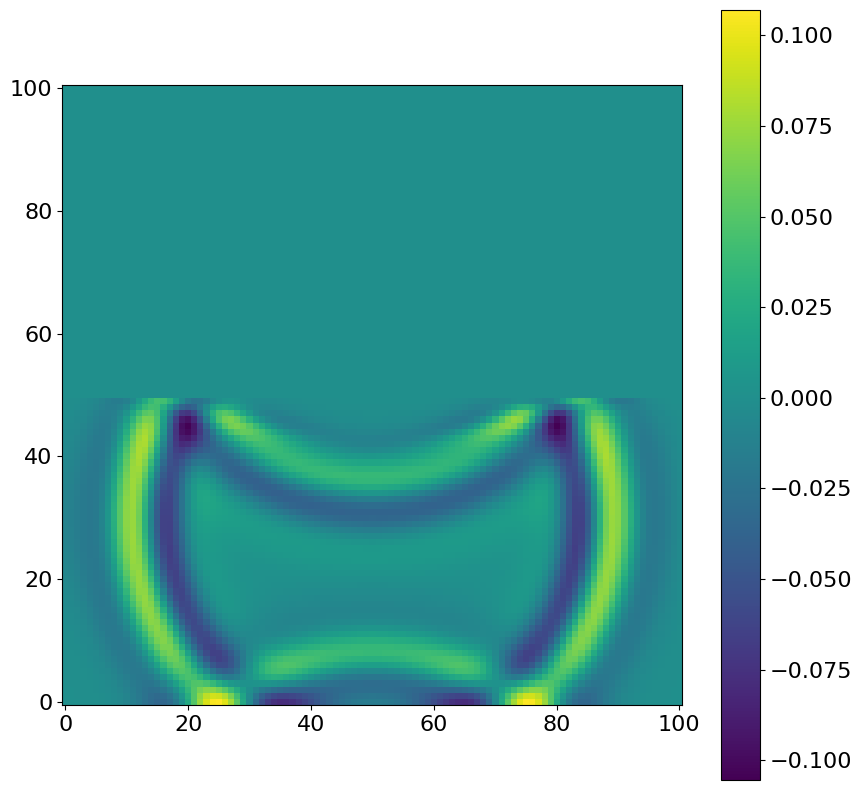

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(tau[0, 0].data[1].T, origin='lower')
plt.colorbar()
plt.show()

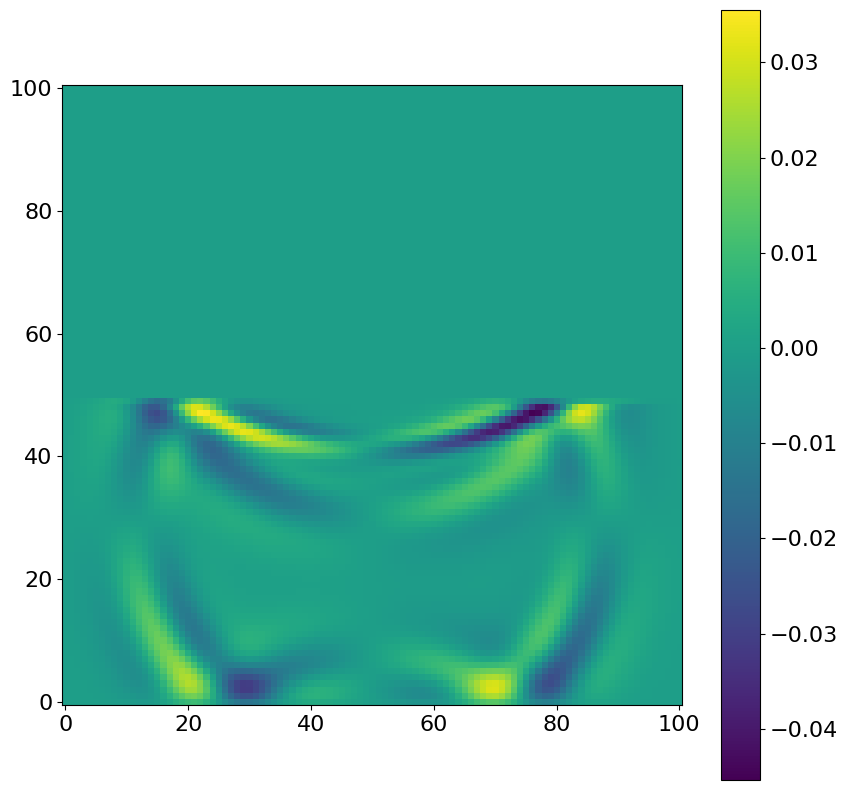

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(tau[0, 1].data[1].T, origin='lower')
plt.colorbar()
plt.show()

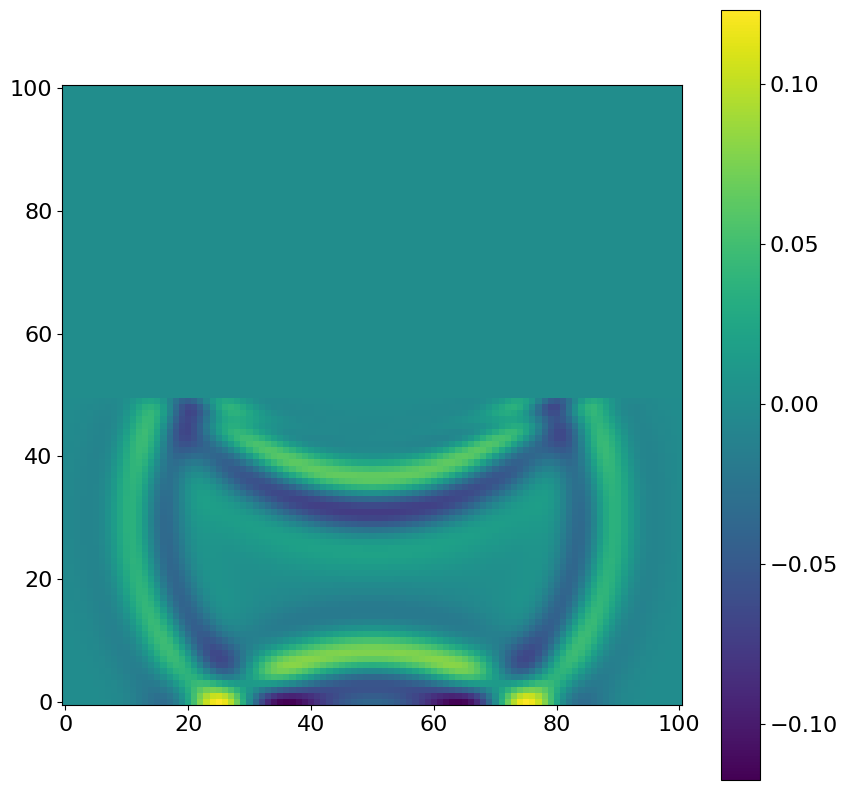

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(tau[1, 1].data[1].T, origin='lower')
plt.colorbar()
plt.show()

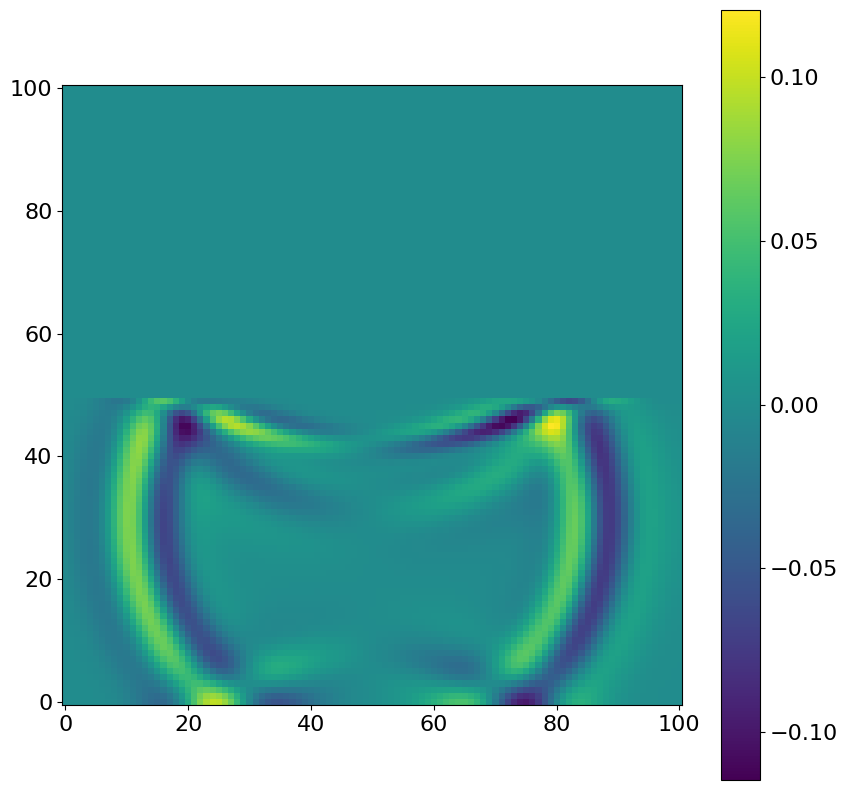

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(v[0].data[1].T, origin='lower')
plt.colorbar()
plt.show()

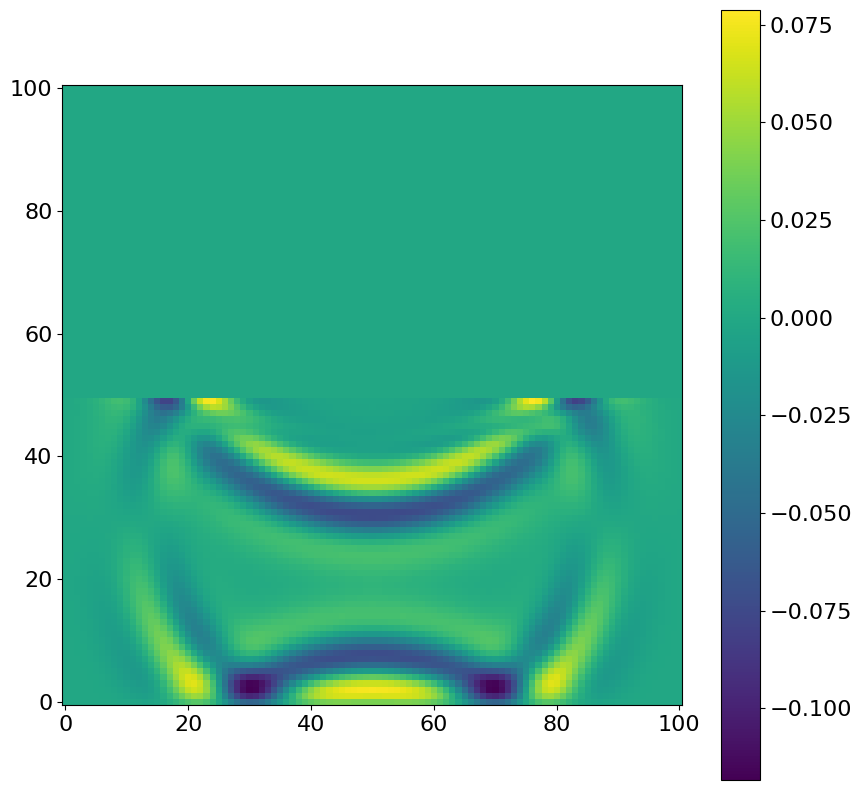

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(v[1].data[1].T, origin='lower')
plt.colorbar()
plt.show()

Note that the reflection off the immersed boundary results in a PS conversion, which is not seen when the wave hits the bottom of the domain.